In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [2]:
@tdmclient.notebook.sync_var
def apply_motor_commands(v_r,v_l):
  # Applies the commands v_l and v_r to the Thymio's motors
  # Inputs : v_r (int), v_l (int)
  # Outputs: None

  global motor_left_target, motor_right_target
  motor_left_target = v_l
  motor_right_target = v_r

@tdmclient.notebook.sync_var
def stop_Thymio():
  # Stops the Thymio robot

  global motor_left_target,motor_right_target
  motor_left_target = 0
  motor_right_target = 0

@tdmclient.notebook.sync_var
def get_motor_speeds():
  # Returns the speeds of the motors : motor.left.speed and motor.right.speed variables from the Thymio
  # Outputs : left_motor_speed (int), right_motor_speed (int)

  global motor_left_speed, motor_right_speed
  return motor_right_speed, motor_left_speed

@tdmclient.notebook.sync_var
def get_prox_sensors():
  # Returns the values of the proximity sensors of the Thymio in a list. Indices [0-4] correspond to the front facing ones (indexed from left to right) and [5-6] are the backwards facing sensors
  # Outputs : prox_horizontal (list of ints of length 7)

  global prox_horizontal
  return prox_horizontal

In [4]:
stop_Thymio()

In [5]:
def wrap_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

print(wrap_to_pi(14.137))

1.570629385640828


In [ ]:
#apply_motor_commands(-10, 10) # turns CW
apply_motor_commands(10, -10) # turns CCW

In [3]:
import warnings
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

from global_variables import *
from computer_vision import *
from kalman import *
from global_navigation import *
from local_navigation import *
from motion_control import *

Mahalanobis distance: 22.239 Y [ 0.32926409 -0.36264252 -0.03559281]
Mahalanobis distance: 18.854 Y [ 0.47641693 -0.14672217 -0.04930647]
Mahalanobis distance: 33.079 Y [ 0.46670191 -0.384279   -0.04968799]
Mahalanobis distance: 34.996 Y [ 0.51120196 -0.36103542 -0.08279621]
Mahalanobis distance: 49.544 Y [ 0.66124957 -0.37966509 -0.07763782]
Mahalanobis distance: 51.519 Y [ 0.65819542 -0.40317968 -0.09680241]
Mahalanobis distance: 105.230 Y [ 0.88367804 -0.64655904 -0.09046593]
Mahalanobis distance: 71.228 Y [ 0.96055842 -0.26260537 -0.09337793]
Mahalanobis distance: 112.926 Y [ 1.26048331 -0.28609688 -0.07001042]
Mahalanobis distance: 87.509 Y [ 1.2114957  -0.12822781 -0.08681042]
Mahalanobis distance: 81.795 Y [ 1.24200291 -0.08309307 -0.06960944]
Mahalanobis distance: 75.593 Y [ 1.28054608 -0.02935564 -0.06720944]
Mahalanobis distance: 87.827 Y [ 1.48370967  0.0122866  -0.06480944]
Mahalanobis distance: 97.709 Y [ 1.57455382 -0.13722641 -0.06160944]
Mahalanobis distance: 85.365 Y [

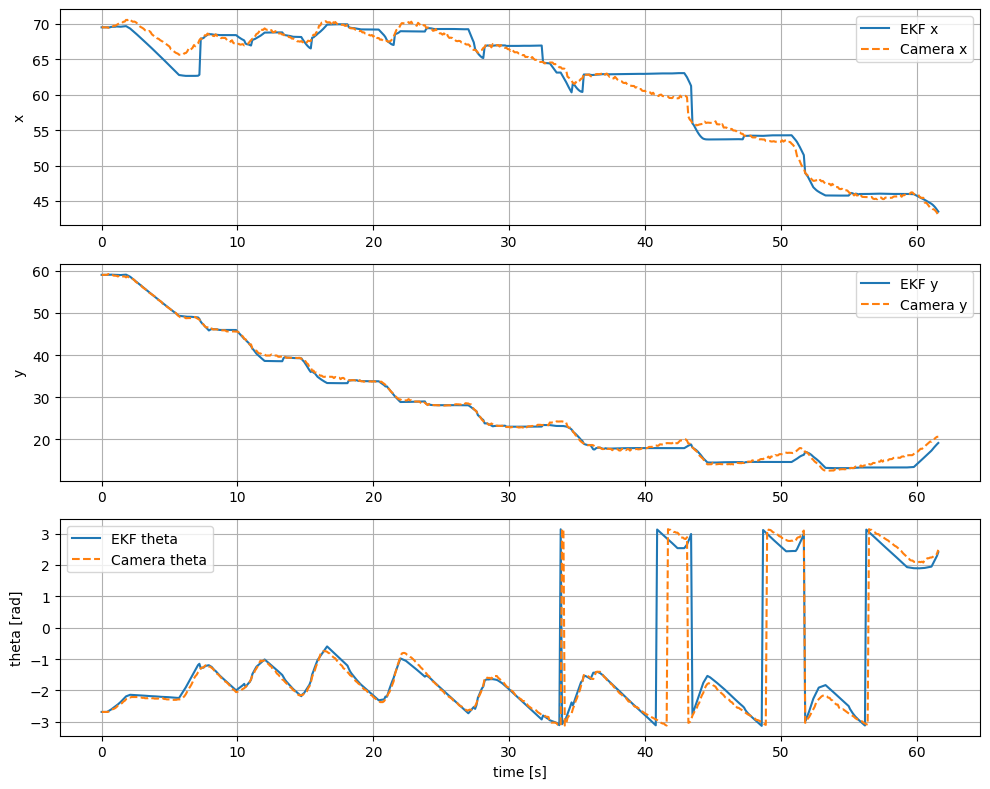

In [4]:
import warnings
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

from global_variables import *
from computer_vision import *
from kalman import *
from global_navigation import *
from local_navigation import *
from motion_control import *

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Could not open webcam")
    exit()

# Global variables
state = "GLOBAL_NAVIGATION"
thymio_start = thymio_theta = goal = polygons = homography = None
theta_des = 0.0
waypoints = None
waypoint_index = 1 # 1 because 0 is the initial position
X_array = [] # vector state logging over time
X_camera_array = [] # vector state from camera logging over time
X = None
P = np.array([[var_x_cam,0,0],[0,var_y_cam,0],[0,0,var_theta_cam]])
prox_values = np.array([0,0,0,0,0,0,0])

# def enter_local_navigation():
#     reset_local_state()
#     state = "LOCAL_NAVIGATION"

while True:
    current_time = time.time()
    ret, frame = cap.read()
    if not ret:
        print("Frame not received")
        break
        
    # CHECK FOR LOCAL NAVIGATION TRIGGER HERE --------------------------------------------------------------------------
    prox_values = get_prox_sensors()
    
    if state == "GLOBAL_NAVIGATION":
        thymio_start, thymio_theta, goal, polygons_real_world, homography = get_pose_from_frame(frame, only_thymio=False)
        if thymio_start is None or thymio_theta is None or goal is None:
            cv2.imshow("Feed", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            continue  # wait for a usable frame

        waypoints = get_global_path(thymio_start, goal, polygons_real_world, plot=False)
        if waypoints is None:
            # no path found -> stop and wait
            print("no path")
            apply_motor_commands(0, 0)
            cv2.imshow("Feed", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            continue

        # initialize state X for kalman filter
        X = np.array([thymio_start[0], thymio_start[1], thymio_theta])
        waypoint_index = 1
        state = "ROTATE"

    else:
        # ROTATE / FORWARD: only need Thymio pose (kalman should be here normally)
        thymio_start, thymio_theta = get_pose_from_frame(frame, only_thymio=True)
        if thymio_start is not None and thymio_theta is not None:
            # UPDATE KALMAN FILTER HERE --------------------------------------------------------------------------
            v_r_motor, v_l_motor = get_motor_speeds()
            X, P = update_EKF(thymio_start, thymio_theta, v_r_motor, v_l_motor, X, P, frame)
            #print(f"Kalman pose: x={X[0]:.3f} m, y={X[1]:.3f} m, theta={X[2]:.3f} rad")  # debug

            X_array.append(X.copy()) # copy to avoid corruption
            # Debug: override kalman with camera measurement
            # X[0] = thymio_start[0]
            # X[1] = thymio_start[1]
            # X[2] = thymio_theta
            X_camera_array.append(np.array([thymio_start[0], thymio_start[1], thymio_theta]))


            # CHECK FOR KIDNAPPING HERE --------------------------------------------------------------------------
            if len(X_array) >= 2:
                x_diff = X_array[-1][0] - X_array[-2][0]
                y_diff = X_array[-1][1] - X_array[-2][1]
            else:
                x_diff = 0
                y_diff = 0
            dist_moved = np.linalg.norm([x_diff, y_diff])
            if dist_moved > KIDNAPPING_THRESHOLD:  # threshold for kidnapping detection
                print("Kidnapping detected")
                state = "GLOBAL_NAVIGATION"

    if state == "ROTATE":
        if check_obstacle_trigger(prox_values):
            local_nav_log("Obstacle detected! Switching to Local.")
            # enter_local_navigation()
            reset_local_state()
            state = "LOCAL_NAVIGATION"
            
        theta_des = np.arctan2(waypoints[1, waypoint_index]-X[1], waypoints[0, waypoint_index]-X[0])
        delta_theta = (theta_des - X[2] + np.pi) % (2*np.pi) - np.pi

        #print(f"theta_des={theta_des:.3f}, theta={X[2]:.3f}, delta={delta_theta:.3f}") # debug

        if abs(delta_theta) < eps_theta:
            apply_motor_commands(0, 0)
            state = "FORWARD"
        elif delta_theta > 0:
            apply_motor_commands(-ROTATION_SPEED,ROTATION_SPEED)
        else:
            apply_motor_commands(ROTATION_SPEED, -ROTATION_SPEED)

    elif state == "FORWARD":
        # CHECK FOR LOCAL NAVIGATION TRIGGER HERE --------------------------------------------------------------------------
        if check_obstacle_trigger(prox_values):
            local_nav_log("Obstacle detected! Switching to Local.")
            # enter_local_navigation()
            reset_local_state()
            state = "LOCAL_NAVIGATION"
        
        x_diff = waypoints[0,waypoint_index] - X[0]
        y_diff = waypoints[1,waypoint_index] - X[1]
        dist_to_waypoint = np.linalg.norm([x_diff, y_diff])

        #print(f"Distance to waypoint: {dist_to_waypoint:.3f} m") # debug

        if dist_to_waypoint < eps_d:
            apply_motor_commands(0,0)
            waypoint_index += 1
            if waypoint_index >= waypoints.shape[1]:
                break
            state = "ROTATE" # reached waypoint
        else:
            #apply_motor_commands(FORWARD_SPEED, FORWARD_SPEED) # move forward
            v_r, v_l = forward_P_regulator( X, waypoints[:, waypoint_index], FORWARD_SPEED)
            apply_motor_commands(v_r, v_l)

    elif state == "LOCAL_NAVIGATION":
        print("State: LOCAL NAV")

        # Logic
        left_speed, right_speed = local_nav_update(prox_values)
        print(left_speed, right_speed)
        print(prox_values)

        # Act
        apply_motor_commands(right_speed, left_speed)

        # Exit Condition
        if current_state == "GLOBAL" and max(prox_values[:5]) < THRESH_ENTRY:
            
            local_nav_log("Obstacle cleared. Returning to Global.")
            stop_Thymio()
            state = "GLOBAL_NAVIGATION"

    if waypoints is not None and homography is not None:
        draw_global_path(frame, homography, waypoints)
        
    cv2.imshow("Feed", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    elapsed = time.time() - current_time
    if elapsed < dt: 
        time.sleep(dt - elapsed)

print("Thymio reached goal")

cap.release()
cv2.destroyAllWindows()

# PLOTTING THE KALMAN FILTER RESULTS ----------------------------------------

X_np      = np.array(X_array)         # shape (N, 3)
Xcam_np   = np.array(X_camera_array)  # shape (N, 3)
t         = np.arange(len(X_np)) * dt # or np.arange(len(X_np))

plt.figure(figsize=(10, 8))

# x
plt.subplot(3, 1, 1)
plt.plot(t, X_np[:, 0],    label="EKF x")
plt.plot(t, Xcam_np[:, 0], label="Camera x", linestyle="--")
plt.ylabel("x")
plt.legend()
plt.grid(True)

# y
plt.subplot(3, 1, 2)
plt.plot(t, X_np[:, 1],    label="EKF y")
plt.plot(t, Xcam_np[:, 1], label="Camera y", linestyle="--")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# theta
plt.subplot(3, 1, 3)
plt.plot(t, X_np[:, 2],    label="EKF theta")
plt.plot(t, Xcam_np[:, 2], label="Camera theta", linestyle="--")
plt.xlabel("time [s]")
plt.ylabel("theta [rad]")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()